# Image Patch Splitting for CNN Models

This notebook demonstrates various techniques for splitting images into patches, which is useful for CNN training, data augmentation, and handling large images. Using [open-cv](https://pypi.org/project/opencv-python/), [scikit-learn](https://pypi.org/project/scikit-learn/), [PyTorch](https://pytorch.org/), [torchvision](https://docs.pytorch.org/vision/stable/index.html)

## Table of Contents
1. [Introduction](#1.-Introduction)
2. [Setup and Imports](#2.-Setup-and-Imports)
3. [Basic Image Patching](#3.-Basic-Image-Patching)
4. [Advanced Patching Techniques](#4.-Advanced-Patching-Techniques)
5. [Patch Reconstruction](#5.-Patch-Reconstruction)
6. [CNN Integration Examples](#6.-CNN-Integration-Examples)
7. [Performance Optimization](#7.-Performance-Optimization)


## 1. Introduction

Image patching is a technique where we divide a large image into smaller, overlapping or non-overlapping patches. This is useful for:
- Training CNNs on high-resolution images
- Data augmentation
- Memory efficiency
- Handling images larger than model input size
- Creating sliding window predictions

## 2. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.feature_extraction import image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## 3. Basic Image Patching

### 3.1 Load and Prepare Sample Image

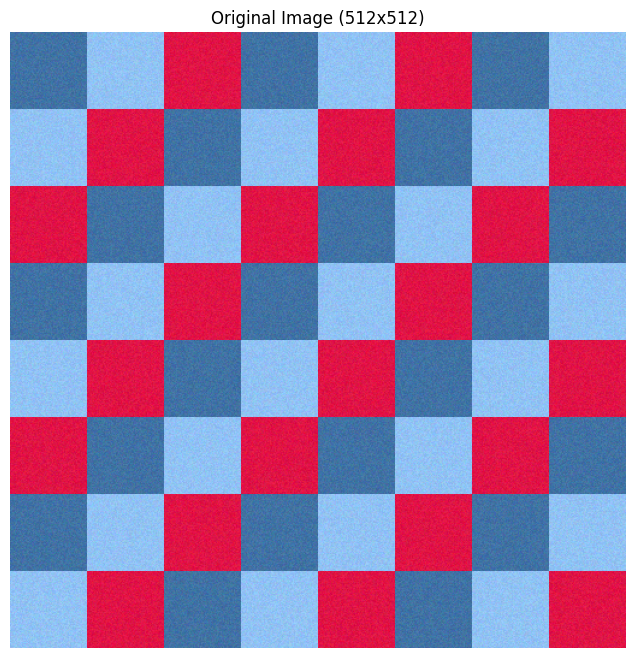

Original image shape: (512, 512, 3)


In [2]:
# Create a sample image or load your own
def create_sample_image(height=512, width=512):
    """Create a sample image with patterns for demonstration"""
    image = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Add some patterns
    for i in range(0, height, 64):
        for j in range(0, width, 64):
            color = ((i//64 + j//64) % 3) * 80 + 50
            image[i:i+64, j:j+64] = [color, (color + 50) % 255, (color + 100) % 255]
    
    # Add some noise for texture
    noise = np.random.randint(0, 30, (height, width, 3))
    image = np.clip(image + noise, 0, 255)
    
    return image.astype(np.uint8)

# Create sample image
sample_image = create_sample_image(512, 512)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(sample_image)
plt.title('Original Image (512x512)')
plt.axis('off')
plt.show()

print(f"Original image shape: {sample_image.shape}")

### 3.2 Simple Non-Overlapping Patches

Number of patches: 64
Patch shape: (64, 64, 3)


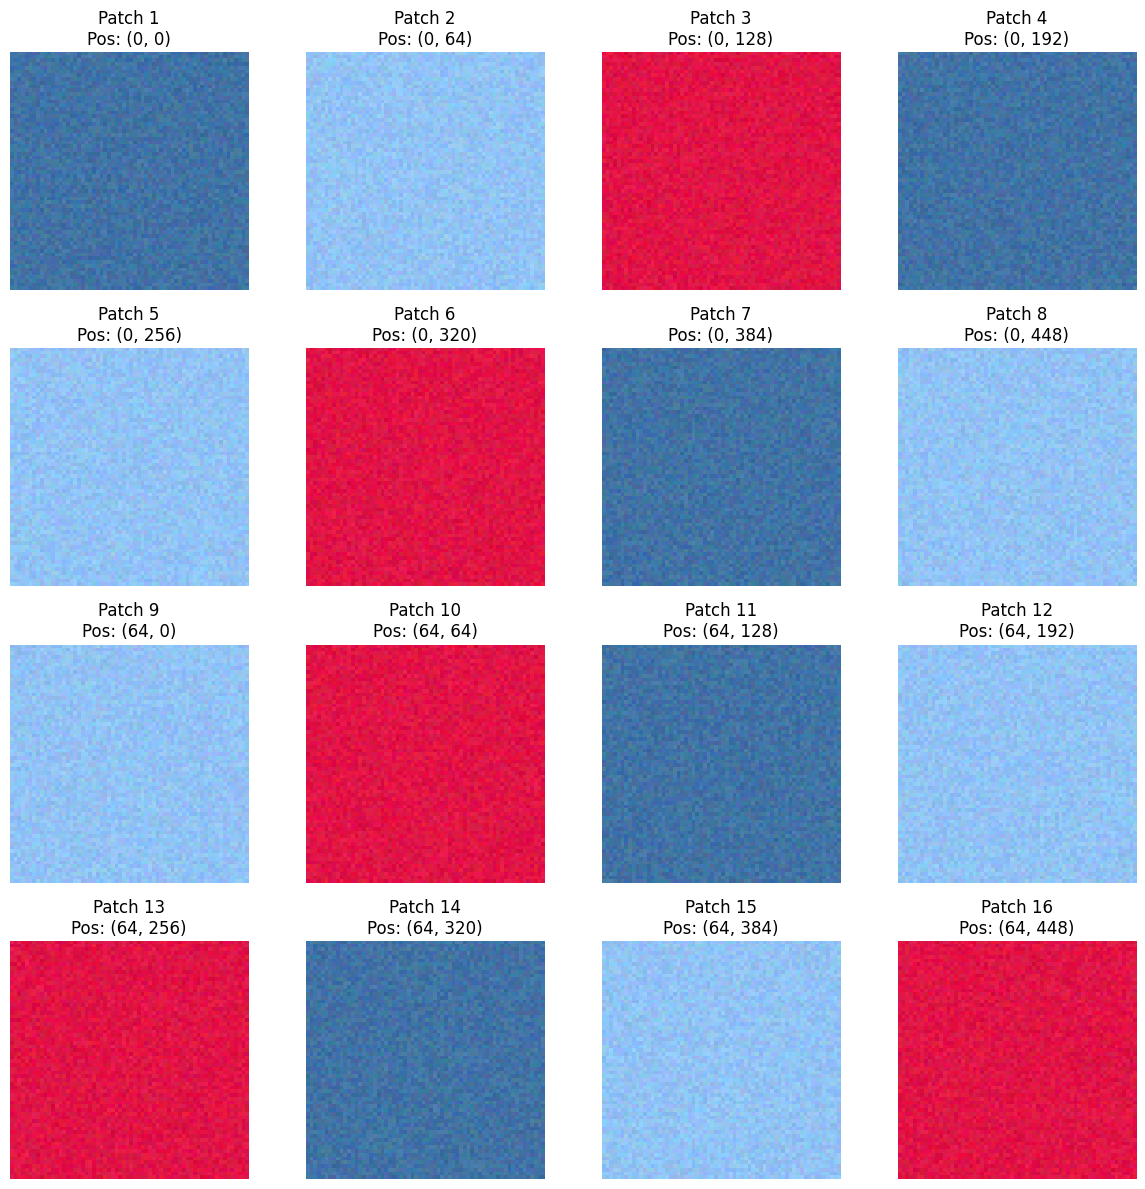

In [3]:
def extract_patches_simple(image, patch_size):
    """
    Extract non-overlapping patches from an image
    
    Args:
        image: Input image (H, W, C) or (H, W)
        patch_size: Size of each patch (height, width)
    
    Returns:
        patches: Array of patches
        positions: Positions of each patch in original image
    """
    if len(image.shape) == 2:
        h, w = image.shape
        c = 1
        image = image.reshape(h, w, 1)
    else:
        h, w, c = image.shape
    
    patch_h, patch_w = patch_size
    
    # Calculate number of patches
    n_patches_h = h // patch_h
    n_patches_w = w // patch_w
    
    patches = []
    positions = []
    
    for i in range(n_patches_h):
        for j in range(n_patches_w):
            # Extract patch
            start_h = i * patch_h
            end_h = start_h + patch_h
            start_w = j * patch_w
            end_w = start_w + patch_w
            
            patch = image[start_h:end_h, start_w:end_w]
            patches.append(patch)
            positions.append((start_h, start_w))
    
    return np.array(patches), positions

# Extract 64x64 patches
patches, positions = extract_patches_simple(sample_image, (64, 64))

print(f"Number of patches: {len(patches)}")
print(f"Patch shape: {patches[0].shape}")

# Visualize first 16 patches
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i < len(patches):
        ax.imshow(patches[i])
        ax.set_title(f'Patch {i+1}\nPos: {positions[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

### 3.3 Overlapping Patches with Stride

Number of overlapping patches: 225
Overlap ratio: 3.52x more patches


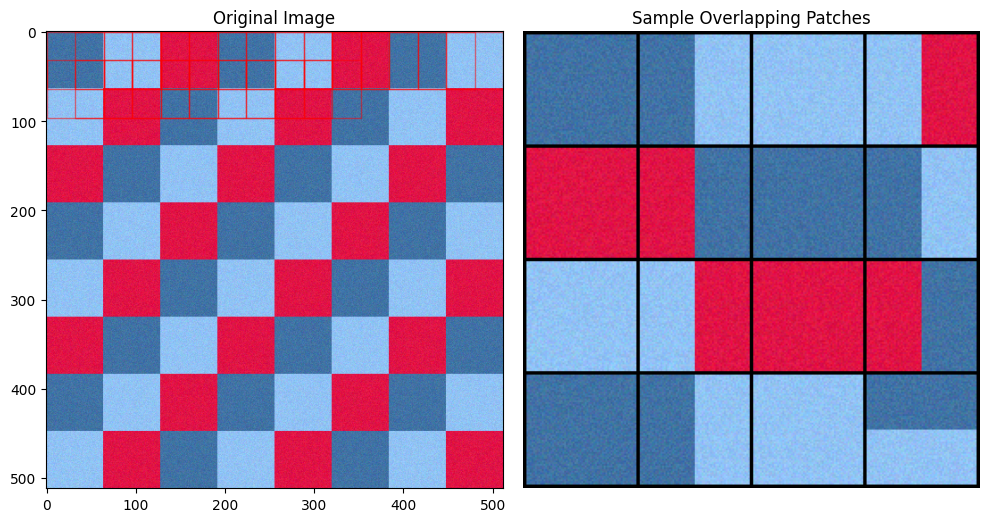

In [4]:
def extract_patches_stride(image, patch_size, stride):
    """
    Extract overlapping patches using stride
    
    Args:
        image: Input image (H, W, C)
        patch_size: Size of each patch (height, width)
        stride: Stride for patch extraction (stride_h, stride_w)
    
    Returns:
        patches: Array of patches
        positions: Positions of each patch
    """
    if len(image.shape) == 2:
        h, w = image.shape
        image = image.reshape(h, w, 1)
    else:
        h, w, c = image.shape
    
    patch_h, patch_w = patch_size
    stride_h, stride_w = stride
    
    patches = []
    positions = []
    
    # Calculate possible positions
    for i in range(0, h - patch_h + 1, stride_h):
        for j in range(0, w - patch_w + 1, stride_w):
            patch = image[i:i+patch_h, j:j+patch_w]
            patches.append(patch)
            positions.append((i, j))
    
    return np.array(patches), positions

# Extract overlapping patches with stride=32
overlapping_patches, overlap_positions = extract_patches_stride(
    sample_image, (64, 64), (32, 32)
)

print(f"Number of overlapping patches: {len(overlapping_patches)}")
print(f"Overlap ratio: {len(overlapping_patches) / len(patches):.2f}x more patches")

# Visualize overlap pattern
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title('Original Image')

# Draw patch boundaries
for pos in overlap_positions[:25]:  # Show first 25 patches
    rect = plt.Rectangle(pos[::-1], 64, 64, fill=False, edgecolor='red', alpha=0.5)
    plt.gca().add_patch(rect)

plt.subplot(1, 2, 2)
# Show some overlapping patches
fig_patches = overlapping_patches[:16]
# Convert to float and normalize to [0, 1] range
patches_tensor = torch.from_numpy(fig_patches).float() / 255.0
grid_img = make_grid(patches_tensor.permute(0, 3, 1, 2), nrow=4, normalize=False)
plt.imshow(grid_img.permute(1, 2, 0))
plt.title('Sample Overlapping Patches')
plt.axis('off')
plt.tight_layout()
plt.show()

## 4. Advanced Patching Techniques

### 4.1 Using sklearn's extract_patches_2d

Sklearn patches shape: (100, 64, 64, 3)


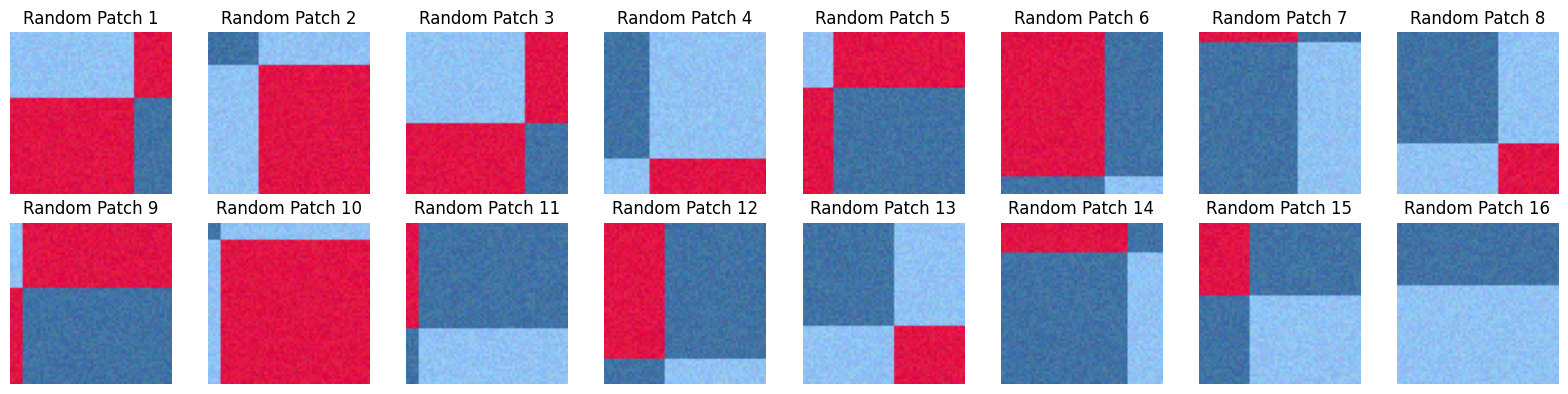

In [5]:
from sklearn.feature_extraction import image as sk_image

def extract_patches_sklearn(image, patch_size, max_patches=None, random_state=42):
    """
    Extract patches using sklearn's extract_patches_2d
    
    Args:
        image: Input image
        patch_size: (height, width) of patches
        max_patches: Maximum number of patches to extract (None for all)
        random_state: Random seed for patch selection
    
    Returns:
        patches: Extracted patches
    """
    # sklearn works with grayscale or single channel, so we'll process each channel
    if len(image.shape) == 3:
        patches_list = []
        for channel in range(image.shape[2]):
            channel_patches = sk_image.extract_patches_2d(
                image[:, :, channel], 
                patch_size, 
                max_patches=max_patches,
                random_state=random_state
            )
            patches_list.append(channel_patches)
        
        # Combine channels
        patches = np.stack(patches_list, axis=-1)
    else:
        patches = sk_image.extract_patches_2d(
            image, patch_size, max_patches=max_patches, random_state=random_state
        )
    
    return patches

# Extract random patches using sklearn
sklearn_patches = extract_patches_sklearn(sample_image, (64, 64), max_patches=100)
print(f"Sklearn patches shape: {sklearn_patches.shape}")

# Visualize random patches
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    if i < len(sklearn_patches):
        ax.imshow(sklearn_patches[i])
        ax.set_title(f'Random Patch {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

### 4.2 Patch Extraction with Padding

Original image shape: (512, 512, 3)
Padded image shape: (512, 512, 3)
Number of patches with padding: 64


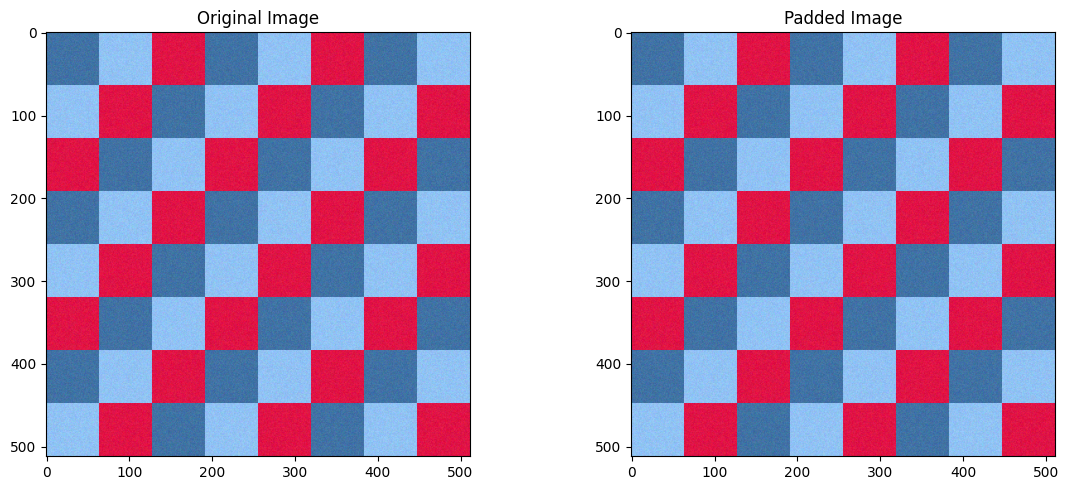

In [6]:
def extract_patches_with_padding(image, patch_size, stride, padding_mode='reflect'):
    """
    Extract patches with padding to handle edge cases
    
    Args:
        image: Input image
        patch_size: (height, width) of patches
        stride: (stride_h, stride_w)
        padding_mode: Padding mode ('reflect', 'constant', 'edge', 'wrap')
    
    Returns:
        patches: Extracted patches
        positions: Original positions before padding
    """
    patch_h, patch_w = patch_size
    stride_h, stride_w = stride
    
    # Calculate required padding
    h, w = image.shape[:2]
    pad_h = (patch_h - h % stride_h) % stride_h
    pad_w = (patch_w - w % stride_w) % stride_w
    
    # Pad image
    if len(image.shape) == 3:
        padded_image = np.pad(image, 
                             ((0, pad_h), (0, pad_w), (0, 0)), 
                             mode=padding_mode)
    else:
        padded_image = np.pad(image, 
                             ((0, pad_h), (0, pad_w)), 
                             mode=padding_mode)
    
    # Extract patches from padded image
    patches, positions = extract_patches_stride(padded_image, patch_size, stride)
    
    return patches, positions, padded_image

# Extract patches with padding
padded_patches, padded_positions, padded_img = extract_patches_with_padding(
    sample_image, (64, 64), (64, 64), padding_mode='reflect'
)

print(f"Original image shape: {sample_image.shape}")
print(f"Padded image shape: {padded_img.shape}")
print(f"Number of patches with padding: {len(padded_patches)}")

# Visualize padding effect
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(padded_img)
plt.title('Padded Image')
plt.tight_layout()
plt.show()

## 5. Patch Reconstruction

### 5.1 Reconstruct from Non-Overlapping Patches

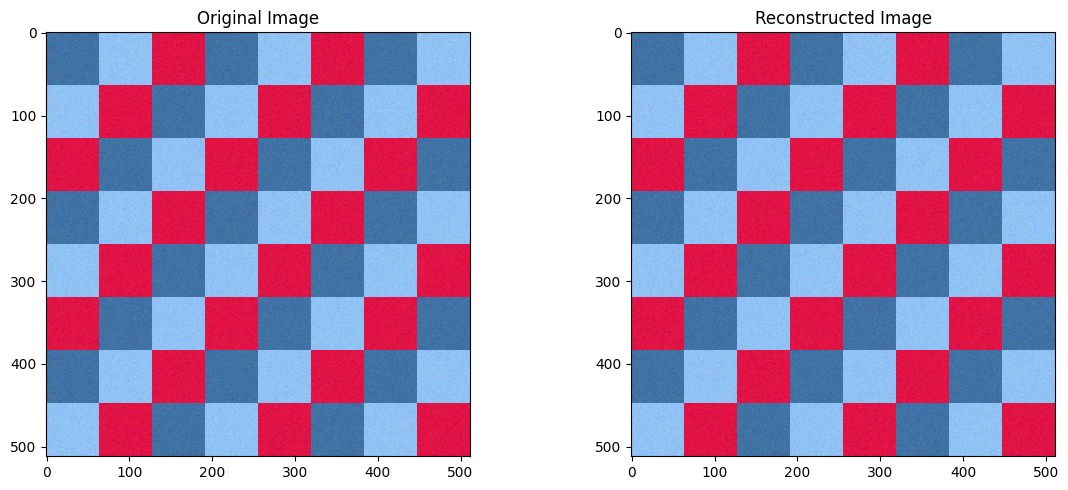

Reconstruction error: 0.0


In [7]:
def reconstruct_from_patches(patches, positions, original_shape, patch_size):
    """
    Reconstruct image from non-overlapping patches
    
    Args:
        patches: Array of patches
        positions: Positions of each patch
        original_shape: Shape of original image
        patch_size: Size of each patch
    
    Returns:
        reconstructed_image: Reconstructed image
    """
    if len(original_shape) == 3:
        h, w, c = original_shape
        reconstructed = np.zeros((h, w, c), dtype=patches.dtype)
    else:
        h, w = original_shape
        reconstructed = np.zeros((h, w), dtype=patches.dtype)
        c = 1
    
    patch_h, patch_w = patch_size
    
    for patch, (start_h, start_w) in zip(patches, positions):
        end_h = min(start_h + patch_h, h)
        end_w = min(start_w + patch_w, w)
        
        if len(original_shape) == 3:
            reconstructed[start_h:end_h, start_w:end_w] = patch
        else:
            reconstructed[start_h:end_h, start_w:end_w] = patch.squeeze()
    
    return reconstructed

# Reconstruct image
reconstructed = reconstruct_from_patches(patches, positions, sample_image.shape, (64, 64))

# Compare original and reconstructed
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed)
plt.title('Reconstructed Image')

plt.tight_layout()
plt.show()

# Check if reconstruction is perfect
print(f"Reconstruction error: {np.mean(np.abs(sample_image - reconstructed))}")

### 5.2 Reconstruct from Overlapping Patches

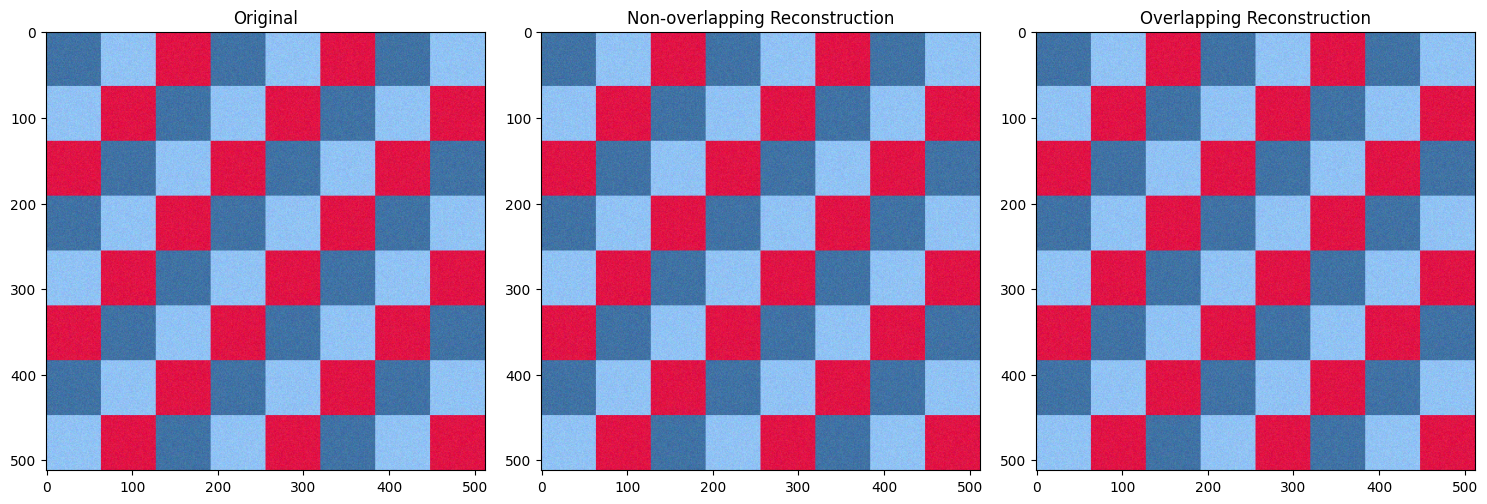

Non-overlapping reconstruction error: 0.0
Overlapping reconstruction error: 0.0


In [8]:
def reconstruct_from_overlapping_patches(patches, positions, original_shape, patch_size):
    """
    Reconstruct image from overlapping patches using averaging
    
    Args:
        patches: Array of patches
        positions: Positions of each patch
        original_shape: Shape of original image
        patch_size: Size of each patch
    
    Returns:
        reconstructed_image: Reconstructed image
    """
    if len(original_shape) == 3:
        h, w, c = original_shape
        reconstructed = np.zeros((h, w, c), dtype=np.float64)
        count_map = np.zeros((h, w, c), dtype=np.float64)
    else:
        h, w = original_shape
        reconstructed = np.zeros((h, w), dtype=np.float64)
        count_map = np.zeros((h, w), dtype=np.float64)
    
    patch_h, patch_w = patch_size
    
    for patch, (start_h, start_w) in zip(patches, positions):
        end_h = min(start_h + patch_h, h)
        end_w = min(start_w + patch_w, w)
        
        patch_actual = patch[:end_h-start_h, :end_w-start_w]
        
        if len(original_shape) == 3:
            reconstructed[start_h:end_h, start_w:end_w] += patch_actual
            count_map[start_h:end_h, start_w:end_w] += 1
        else:
            reconstructed[start_h:end_h, start_w:end_w] += patch_actual.squeeze()
            count_map[start_h:end_h, start_w:end_w] += 1
    
    # Average overlapping regions
    reconstructed = reconstructed / np.maximum(count_map, 1)
    
    return reconstructed.astype(np.uint8)

# Reconstruct from overlapping patches
overlap_reconstructed = reconstruct_from_overlapping_patches(
    overlapping_patches, overlap_positions, sample_image.shape, (64, 64)
)

# Compare reconstructions
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title('Original')

plt.subplot(1, 3, 2)
plt.imshow(reconstructed)
plt.title('Non-overlapping Reconstruction')

plt.subplot(1, 3, 3)
plt.imshow(overlap_reconstructed)
plt.title('Overlapping Reconstruction')

plt.tight_layout()
plt.show()

print(f"Non-overlapping reconstruction error: {np.mean(np.abs(sample_image - reconstructed))}")
print(f"Overlapping reconstruction error: {np.mean(np.abs(sample_image - overlap_reconstructed))}")

## 6. CNN Integration Examples

### 6.1 PyTorch Dataset for Patches

Dataset size: 100
Number of batches: 7
Batch shape: torch.Size([16, 3, 64, 64])


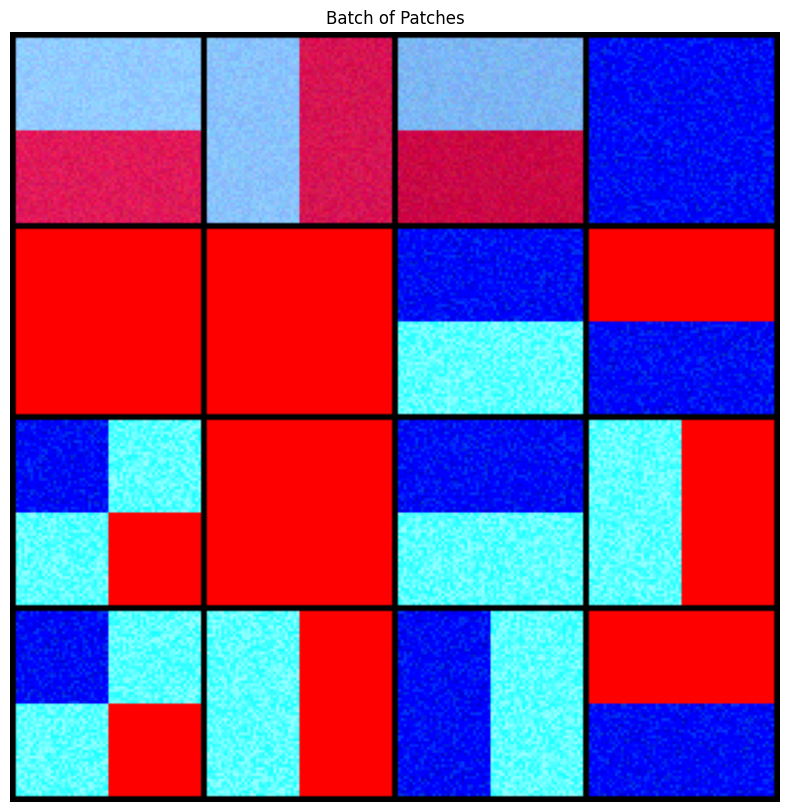

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader

class PatchDataset(Dataset):
    """Dataset class for image patches"""
    
    def __init__(self, images, patch_size, stride=None, transform=None, max_patches_per_image=None):
        """
        Args:
            images: List of images or single image
            patch_size: (height, width) of patches
            stride: Stride for patch extraction (default: patch_size for non-overlapping)
            transform: Optional transform to be applied to patches
            max_patches_per_image: Maximum patches per image (for memory management)
        """
        self.patch_size = patch_size
        self.stride = stride if stride is not None else patch_size
        self.transform = transform
        
        # Extract all patches
        self.patches = []
        self.labels = []  # You can add labels here if needed
        
        if not isinstance(images, list):
            images = [images]
        
        for img_idx, image in enumerate(images):
            patches, _ = extract_patches_stride(image, patch_size, self.stride)
            
            # Limit patches per image if specified
            if max_patches_per_image and len(patches) > max_patches_per_image:
                indices = np.random.choice(len(patches), max_patches_per_image, replace=False)
                patches = patches[indices]
            
            self.patches.extend(patches)
            self.labels.extend([img_idx] * len(patches))  # Image index as label
    
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        patch = self.patches[idx]
        label = self.labels[idx]
        
        # Convert to PIL Image for transforms
        if self.transform:
            patch = Image.fromarray(patch)
            patch = self.transform(patch)
        else:
            # Convert to tensor
            patch = torch.from_numpy(patch).float().permute(2, 0, 1) / 255.0
        
        return patch, label

# Create dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = PatchDataset([sample_image], patch_size=(64, 64), stride=(32, 32), 
                      transform=transform, max_patches_per_image=100)

dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

print(f"Dataset size: {len(dataset)}")
print(f"Number of batches: {len(dataloader)}")

# Visualize a batch
batch_patches, batch_labels = next(iter(dataloader))
print(f"Batch shape: {batch_patches.shape}")

# Denormalize for visualization
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

grid = make_grid(denormalize(batch_patches.clone()), nrow=4)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.title('Batch of Patches')
plt.axis('off')
plt.show()

### 6.2 Simple CNN for Patch Classification

In [10]:
class PatchCNN(nn.Module):
    """Simple CNN for patch classification"""
    
    def __init__(self, input_channels=3, num_classes=10, patch_size=64):
        super(PatchCNN, self).__init__()
        
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        
        # Calculate the size after conv layers
        conv_output_size = patch_size // 8  # After 3 MaxPool2d layers
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Create model
model = PatchCNN(input_channels=3, num_classes=5, patch_size=64)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test forward pass
test_input = torch.randn(4, 3, 64, 64)
output = model(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {output.shape}")

Model parameters: 102,277
Input shape: torch.Size([4, 3, 64, 64])
Output shape: torch.Size([4, 5])


## 7. Performance Optimization

### 7.1 Vectorized Patch Extraction

In [11]:
def extract_patches_vectorized(image, patch_size, stride):
    """
    Vectorized patch extraction using numpy stride tricks
    Much faster for large images
    """
    from numpy.lib.stride_tricks import sliding_window_view
    
    if len(image.shape) == 2:
        h, w = image.shape
        image = image.reshape(h, w, 1)
    
    h, w, c = image.shape
    patch_h, patch_w = patch_size
    stride_h, stride_w = stride
    
    # Use sliding window view for efficient patch extraction
    patches = sliding_window_view(image, (patch_h, patch_w, c), axis=(0, 1, 2))
    
    # Subsample according to stride
    patches = patches[::stride_h, ::stride_w, 0]  # Remove singleton dimension
    
    # Reshape to (n_patches, patch_h, patch_w, c)
    n_patches_h, n_patches_w = patches.shape[:2]
    patches = patches.reshape(-1, patch_h, patch_w, c)
    
    return patches

# Compare performance
import time

# Time regular method
start_time = time.time()
regular_patches, _ = extract_patches_stride(sample_image, (64, 64), (16, 16))
regular_time = time.time() - start_time

# Time vectorized method
start_time = time.time()
vectorized_patches = extract_patches_vectorized(sample_image, (64, 64), (16, 16))
vectorized_time = time.time() - start_time

print(f"Regular method: {regular_time:.4f} seconds, {len(regular_patches)} patches")
print(f"Vectorized method: {vectorized_time:.4f} seconds, {len(vectorized_patches)} patches")
print(f"Speedup: {regular_time/vectorized_time:.2f}x")
print(f"Results identical: {np.allclose(regular_patches, vectorized_patches)}")

Regular method: 0.0065 seconds, 841 patches
Vectorized method: 0.0040 seconds, 841 patches
Speedup: 1.63x
Results identical: True


### 7.2 Memory-Efficient Patch Processing

In [12]:
class MemoryEfficientPatchProcessor:
    """Memory-efficient patch processor for large images"""
    
    def __init__(self, patch_size, stride, batch_size=32):
        self.patch_size = patch_size
        self.stride = stride
        self.batch_size = batch_size
    
    def process_image_in_batches(self, image, process_fn):
        """
        Process image patches in batches to save memory
        
        Args:
            image: Input image
            process_fn: Function to apply to each batch of patches
        
        Returns:
            results: List of processing results
        """
        patches, positions = extract_patches_stride(image, self.patch_size, self.stride)
        results = []
        
        for i in range(0, len(patches), self.batch_size):
            batch_patches = patches[i:i+self.batch_size]
            batch_positions = positions[i:i+self.batch_size]
            
            # Convert to tensor
            batch_tensor = torch.from_numpy(batch_patches).float().permute(0, 3, 1, 2) / 255.0
            
            # Process batch
            with torch.no_grad():
                batch_result = process_fn(batch_tensor)
            
            results.extend(batch_result.cpu().numpy())
        
        return results, positions

# Example processing function (feature extraction)
def extract_features(patch_batch):
    """Dummy feature extraction function"""
    # Simple average pooling as feature
    # Use reshape instead of view, or make tensor contiguous first
    return torch.mean(patch_batch.reshape(patch_batch.size(0), -1), dim=1)

# Process image in batches
processor = MemoryEfficientPatchProcessor((64, 64), (32, 32), batch_size=16)
features, patch_positions = processor.process_image_in_batches(sample_image, extract_features)

print(f"Extracted {len(features)} features from patches")
print(f"Feature shape: {np.array(features).shape}")

Extracted 225 features from patches
Feature shape: (225,)


## Conclusion

This notebook covered various techniques for splitting images into patches for CNN models:

1. **Basic patching**: Non-overlapping and overlapping patches
2. **Advanced techniques**: Using sklearn, padding, and vectorized operations
3. **Reconstruction**: Rebuilding images from patches
4. **CNN integration**: PyTorch datasets and model examples
5. **Performance optimization**: Vectorized operations and memory-efficient processing